<a href="https://colab.research.google.com/github/DYNAFEM/REGRESION-PESO-BOVINOS/blob/MODELOS_MULTIMODALES-HIBRIDOS-PARALELO/V00_MOD_MULT_PARALELO_SIN_RESNET50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modelo Multimodal Paralelo Sin ResNet50.

In [ ]:
# Librerias
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Directorios
base_dir = '/content/drive/My Drive/REGRESION_PESO/DATOS_T_ENLACES_IMAGENES'
train_csv = os.path.join(base_dir, 'train_dataset_clean.csv')
test_csv  = os.path.join(base_dir, 'test_dataset_clean.csv')
train_images_dir = os.path.join(base_dir, 'IMAGENES_TRAIN')
test_images_dir  = os.path.join(base_dir, 'IMAGENES_TEST')
IMG_SIZE = (224,224)

In [ ]:
# Carga de Datos
train_df = pd.read_csv(train_csv)
test_df  = pd.read_csv(test_csv)

In [ ]:
# Caracteristicas y Objetivo
X_train_tab = train_df.drop(columns=['weight_in_kg'])
y_train = train_df['weight_in_kg'].values
X_test_tab = test_df.drop(columns=['weight_in_kg'])
y_test = test_df['weight_in_kg'].values

In [ ]:
# Guardar SKU para enlazar imágenes y predicciones
sku_train = X_train_tab['sku'].values
sku_test  = X_test_tab['sku'].values

In [ ]:
# Quitar sku de las features tabulares
X_train_tab = X_train_tab.drop(columns=['sku'])
X_test_tab  = X_test_tab.drop(columns=['sku'])

In [ ]:
# --------------------------------
# FUNCIÓN PARA CARGAR IMÁGENES (MODIFICADA)
# --------------------------------
def load_images(skus, folder):
    images = []
    for sku in skus:
        img_path = os.path.join(folder, f"{sku}.jpg")
        if os.path.exists(img_path):
            img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
            img_array = tf.keras.utils.img_to_array(img) / 255.0
            images.append(img_array)
        else:
            raise FileNotFoundError(f"Imagen no encontrada: {img_path}")
    return np.array(images)

X_train_img = load_images(sku_train, train_images_dir)
X_test_img  = load_images(sku_test, test_images_dir)

In [ ]:
from tensorflow.keras import layers, Input, Model, models
from tensorflow.keras.optimizers import Adam
# Nota: La importación de ResNet50 ya no es necesaria, pero mantienes la de Input y Model.

# --- RAMA IMAGENES CON CNN SIMPLE (Desde Cero) ---
image_input = Input(shape=(224, 224, 3), name="image_branch_input")

# Bloque 1
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Bloque 2
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Bloque 3
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Aplanar y conectar con la salida
x = layers.GlobalAveragePooling2D()(x) # O podrías usar layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)

In [ ]:
# Rama MLP para datos tabulares
tab_input = Input(shape=(X_train_tab.shape[1],))
y = layers.Dense(64, activation='relu')(tab_input)
y = layers.Dense(32, activation='relu')(y)

In [ ]:
# Rama MLP para datos tabulares
# tab_input = Input(shape=(X_train_tab.shape[1],))
# y = layers.Dense(64, activation='relu')(tab_input)
# y = layers.Dense(32, activation='relu')(y)

In [ ]:
# Concatenación
combined = layers.concatenate([x, y])
z = layers.Dense(64, activation='relu')(combined)
z = layers.Dropout(0.3)(z)
output = layers.Dense(1, activation='linear')(z)

In [ ]:
# Modelo final
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Define the optimizer
model = models.Model(inputs=[image_input, tab_input], outputs=output)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_branch_input  │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ image_branch_inp… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ max_pooling2d_2[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      1,088 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     10,304 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 124,193 (485.13 KB)

 Trainable params: 123,745 (483.38 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# ENTRENAMIENTO
tf.config.run_functions_eagerly(True)
history = model.fit(
    [X_train_img, X_train_tab.values], y_train,
    validation_data=([X_test_img, X_test_tab.values], y_test),
    epochs=15,
    batch_size=16
)


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - loss: 64708.3789 - mae: 245.1252 - val_loss: 64615.9805 - val_mae: 247.1599
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step - loss: 35393.2070 - mae: 168.7323 - val_loss: 60880.9297 - val_mae: 239.9050
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - loss: 7114.0142 - mae: 60.8417 - val_loss: 57935.1562 - val_mae: 234.5021
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - loss: 6269.7632 - mae: 54.0862 - val_loss: 54103.2930 - val_mae: 227.5292
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - loss: 5834.0522 - mae: 54.5674 - val_loss: 49190.1719 - val_mae: 217.9643
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - loss: 5630.0864 - mae: 46.7364 - val_loss: 40619.2188 - val_mae: 198.3670
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - loss: 3395.2344 - mae: 41.4288 - val_loss: 31479.1270 - val_mae: 173.7625
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - loss: 2127.2957 - mae: 31.8370 - val_loss: 27065.7422 - v

In [ ]:
# ----------------------
# EVALUACIÓN TEST
# ----------------------
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicción
y_pred = model.predict([X_test_img, X_test_tab.values]).flatten()

# Métricas
mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

# Resultados
print(f"MAE : {mae:.2f} kg")
print(f"MSE : {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.3f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
MAE : 35.00 kg
MSE : 1880.64
RMSE: 43.37
R²  : 0.474


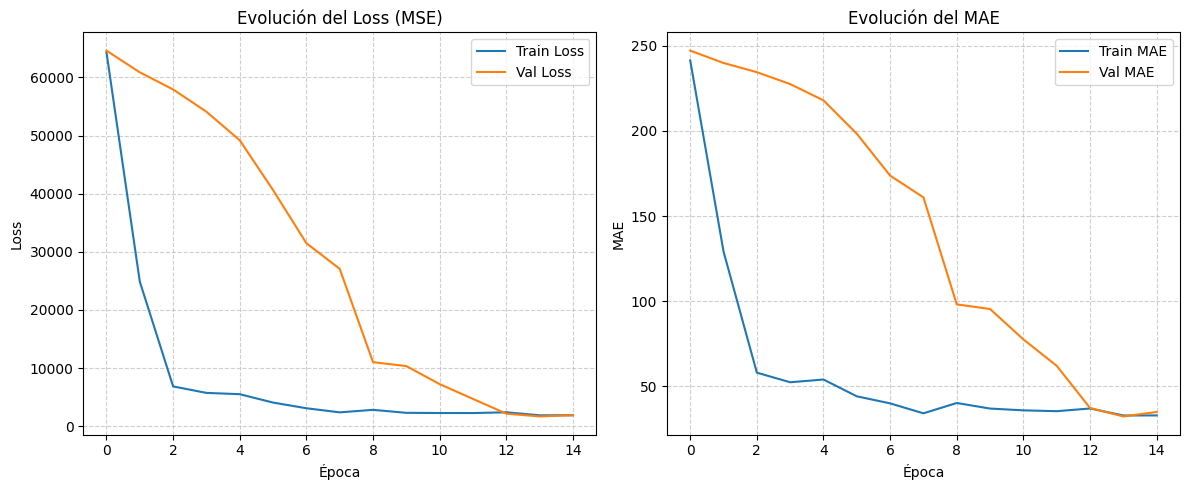

In [ ]:
import matplotlib.pyplot as plt

# Obtener métricas del entrenamiento
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

# Crear figura
plt.figure(figsize=(12, 5))

# --- Gráfica 1: Pérdida (MSE) ---
plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Evolución del Loss (MSE)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# --- Gráfica 2: MAE ---
plt.subplot(1, 2, 2)
plt.plot(mae, label='Train MAE')
plt.plot(val_mae, label='Val MAE')
plt.title('Evolución del MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
# ----------------------
# GUARDAR PREDICCIONES
# ----------------------
pred_df = pd.DataFrame({
    'sku': sku_test,
    'real_weight': y_test,
    'predicted_weight': y_pred
})
pred_path = os.path.join(base_dir, 'predicciones.csv')
pred_df.to_csv(pred_path, index=False)

print(f"✅ Predicciones guardadas en {pred_path}")

✅ Predicciones guardadas en /content/drive/My Drive/REGRESION_PESO/DATOS_T_ENLACES_IMAGENES/predicciones.csv


In [ ]:
### CODIGO COMPLETO


